# Loading Imports

In [1]:
# adding root folder to path
import os
import sys

module_path = os.path.abspath(os.path.join('..'))

if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
# third-party imports
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

from sklearn.multiclass import OneVsRestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.calibration import calibration_curve
from sklearn.calibration import CalibrationDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import brier_score_loss
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

from modAL.models import ActiveLearner

# project import
from commons.file import save_model
from commons.data import encode_data
from commons.classifiers import get_estimator
from commons.classifiers import get_query_strategy
from commons.classifiers import initial_pool_test_split

# Utils

In [3]:
def uncalibrated_active_model(estimator, query_strategy, n_queries, 
                              X_initial, X_pool, y_initial, y_pool):
    
    # initializing selected arrays
    X_selected = X_initial.copy()
    y_selected = y_initial.copy()

    # copying pool arrays
    X_pool_cpy = X_pool.copy()
    y_pool_cpy = y_pool.copy()
    
    learner = ActiveLearner(estimator=get_estimator(estimator),
                            query_strategy=get_query_strategy(query_strategy),
                            X_training=X_initial, y_training=y_initial)

    for _ in range(n_queries):

        query_idx, query_inst = learner.query(X_pool_cpy)

        learner.teach(query_inst.reshape(1, -1), y_pool_cpy[query_idx])

        X_selected = np.append(X_selected, query_inst, axis=0)
        y_selected = np.append(y_selected, y_pool_cpy[query_idx], axis=0)

        X_pool_cpy = np.delete(X_pool_cpy, query_idx, axis=0)
        y_pool_cpy = np.delete(y_pool_cpy, query_idx, axis=0)
    
    uncalibrated = get_estimator(estimator)

    return uncalibrated, X_selected, y_selected

In [4]:
def calibrated_active_model(estimator, query_strategy, calibration_strategy,
                            n_queries, X_initial, X_pool, y_initial, y_pool):

    # initializing selected arrays
    X_selected = X_initial.copy()
    y_selected = y_initial.copy()

    # copying pool arrays
    X_pool_cpy = X_pool.copy()
    y_pool_cpy = y_pool.copy()

    for _ in range(NUMBER_QUERIES):
        try:
            calibrated = CalibratedClassifierCV(
                get_estimator(ESTIMATOR), method=calibration_strategy, cv=5)
            calibrated.fit(X_selected, y_selected)
        except ValueError:
            try:
                calibrated = CalibratedClassifierCV(
                    get_estimator(ESTIMATOR), method=calibration_strategy, cv=KFold(n_splits=2).split(X_selected))
                calibrated.fit(X_selected, y_selected)
            except ValueError:
                print('Not enough samples to perform cross-validation.')

        active_learner = ActiveLearner(calibrated, get_query_strategy(QUERY_STRATEGY))

        query_idx, query_inst = active_learner.query(X_pool_cpy)

        X_selected = np.append(X_selected, query_inst, axis=0)
        y_selected = np.append(y_selected, y_pool_cpy[query_idx], axis=0)

        X_pool_cpy = np.delete(X_pool_cpy, query_idx, axis=0)
        y_pool_cpy = np.delete(y_pool_cpy, query_idx, axis=0)
        
    calibrated = CalibratedClassifierCV(
        get_estimator(ESTIMATOR), method=calibration_strategy, cv=5)

    return calibrated, X_selected, y_selected

In [5]:
def get_y_true(y_test, target):
    return [1 if y == target else 0 for y in y_test]

In [6]:
def get_dummies(y_test):
    targets = list()
    dummies = pd.get_dummies([0, 1, 2, 3]).values

    for i in y_test:
        targets.append(dummies[i].tolist())

    return np.array(targets)

In [7]:
def expected_calibration_error(y_prob, y_true, n_bins=3):
    # calculating bins
    bins_range = np.linspace(0, 1, n_bins + 1)
    bins = {(bins_range[i], bins_range[i + 1]): [] for i in range(n_bins)}

    # assigning the probability values to their specific bins
    for prob, y in zip(prob_pos, y_true):
        y_pred = np.argmax(prob)
        prob_value = prob[y_pred]

        for (start, end), value in bins.items():
            if start < prob_value <= end:
                bins[start, end].append((prob_value, y_pred, y))

    # calculating acc, avg and dif for each bin
    results = {i: {'len': 0.0, 'acc': 0.0, 'avg': 0.0, 'dif': 0.0} for i in range(n_bins)}
    for index, ((start, end), value) in enumerate(bins.items()):
        if len(value) == 0:
            continue

        results[index]['len'] = len(value)

        for prob, y_pred, y in value:
            results[index]['avg'] += prob

            if y_pred == y:
                results[index]['acc'] += 1

    # calculating expected calibration error
    ece = 0.0
    for key, value in results.items():
        if results[key]['len'] == 0:
            continue

        results[key]['acc'] /= results[key]['len']
        results[key]['avg'] /= results[key]['len']
        results[key]['dif'] = np.abs(results[key]['acc'] - results[key]['avg'])

        ece += results[key]['len'] * results[key]['dif']

    return ece / len(y_true)

# Loading data

In [8]:
df = pd.read_csv('../datasets/vulns-labelled.csv')

# droping unused columns
df.drop(columns=[
    'cve_id', 'readable_cve_date', 'reference',
    'readable_exploit_date', 'audience_normalized'], inplace=True)

# encoding dataset
df = encode_data(df)

df['label'].replace(
    {'LOW': 0, 'MODERATE': 1, 'IMPORTANT': 2, 'CRITICAL': 3}, inplace=True)

X = df.drop(columns='label').to_numpy()
y = df['label'].to_numpy()

# Training Clasify

In [9]:
INITIAL_SIZE = 20
TEST_SIZE = 40
NUMBER_QUERIES = 100
N_REPETITIONS = 30
ENCODE_DATA = False
ESTIMATOR = 'gb'
QUERY_STRATEGY = 'entropy-sampling'

In [10]:
classes = ['LOW', 'MODERATE', 'IMPORTANT', 'CRITICAL']
colors = ['#21b803', '#fbbc04', '#f66e0b', '#f41907']

n_classes = len(classes)

In [11]:
uncalibrated_results = {key: list() for key in range(n_classes)}
uncalibrated_results['proba'] = list()
uncalibrated_results['y_test'] = list()
uncalibrated_results['acc'] = list()
uncalibrated_results['ece'] = list()
uncalibrated_results['brier_loss'] = list()

calibrated_sigmoid_results = {key: list() for key in range(n_classes)}
calibrated_sigmoid_results['proba'] = list()
calibrated_sigmoid_results['y_test'] = list()
calibrated_sigmoid_results['acc'] = list()
calibrated_sigmoid_results['ece'] = list()
calibrated_sigmoid_results['brier_loss'] = list()

calibrated_isotonic_results = {key: list() for key in range(n_classes)}
calibrated_isotonic_results['proba'] = list()
calibrated_isotonic_results['y_test'] = list()
calibrated_isotonic_results['acc'] = list()
calibrated_isotonic_results['ece'] = list()
calibrated_isotonic_results['brier_loss'] = list()

In [12]:
for _ in range(N_REPETITIONS):
    # splitting data
    X_initial, X_pool, X_test, y_initial, y_pool, y_test =\
        initial_pool_test_split(X, y, INITIAL_SIZE, TEST_SIZE)
    
    # encoding if necessary
    if ENCODE_DATA:
        scaler = StandardScaler().fit(np.r_[X_initial, X_pool])
        X_initial = scaler.transform(X_initial)
        X_pool = scaler.transform(X_pool)
        X_test = scaler.transform(X_test)
    
    # getting uncalibrated samples
    uncalibrated, X_selected, y_selected =\
        uncalibrated_active_model(
            ESTIMATOR, QUERY_STRATEGY, NUMBER_QUERIES, X_initial, X_pool, y_initial, y_pool)
    
    # getting calibrated sigmoid samples
    calibrated_sigmoid, X_selected_sig, y_selected_sig =\
        calibrated_active_model(
            ESTIMATOR, QUERY_STRATEGY, 'sigmoid', NUMBER_QUERIES, X_initial, X_pool, y_initial, y_pool)
    
    # getting calibrated isotonic samples
    calibrated_isotonic, X_selected_iso, y_selected_iso =\
        calibrated_active_model(
            ESTIMATOR, QUERY_STRATEGY, 'isotonic', NUMBER_QUERIES, X_initial, X_pool, y_initial, y_pool)
    
    clf_list = [
        (uncalibrated, uncalibrated_results, 'Gradient Boosting'),
        (calibrated_sigmoid, calibrated_sigmoid_results, 'Gradient Boosting + Sigmoid'),
        (calibrated_isotonic, calibrated_isotonic_results, 'Gradient Boosting + Isotonic')
    ]

    X_list = [X_selected, X_selected_sig, X_selected_iso]
    y_list = [y_selected, y_selected_sig, y_selected_iso]
    
    
    for (clf, result, name), X_train, y_train in zip(clf_list, X_list, y_list):
        clf.fit(X_train, y_train)
        prob_pos = clf.predict_proba(X_test)
        
        result['proba'].append(prob_pos)
        result['y_test'].append(y_test)
        
        acc = clf.score(X_test, y_test)
        result['acc'].append(acc)
        
        ece = expected_calibration_error(prob_pos, y_test, n_bins=4)
        result['ece'].append(ece)
        
        brier_loss = np.mean(np.sum((prob_pos - get_dummies(y_test)) ** 2, axis=1))
        result['brier_loss'].append(brier_loss)
        
        for target in range(n_classes):
            result[target].append(prob_pos[:, target])

# Results

In [13]:
for (clf, result, name) in clf_list:
    result['proba'] = np.concatenate(result['proba'], axis=0)
    result['y_test'] = np.concatenate(result['y_test'], axis=0)
    
    for target in range(n_classes):
        result[target] = np.concatenate(result[target], axis=0)

# Accuracy

In [14]:
for (clf, result, name) in clf_list:
    print(f"{name} acc: {np.mean(result['acc']):.2f} (std={np.std(result['acc']):.2f})")

Gradient Boosting acc: 0.72 (std=0.06)
Gradient Boosting + Sigmoid acc: 0.73 (std=0.06)
Gradient Boosting + Isotonic acc: 0.73 (std=0.07)


# [Expected Calibration Error](https://jamesmccaffrey.wordpress.com/2021/01/22/how-to-calculate-expected-calibration-error-for-multi-class-classification/)

In [15]:
for (clf, result, name) in clf_list:
    print(f"{name} ece: {np.mean(result['ece']):.2f} (std={np.std(result['ece']):.2f})")

Gradient Boosting ece: 0.17 (std=0.05)
Gradient Boosting + Sigmoid ece: 0.23 (std=0.06)
Gradient Boosting + Isotonic ece: 0.14 (std=0.04)


# [Brier Loss](https://stackoverflow.com/questions/71770524/optimize-classifier-for-multiclass-brier-score-instead-of-accuracy)

In [16]:
for (clf, result, name) in clf_list:
    print(f"{name} brier_loss: {np.mean(result['brier_loss']):.2f} (std={np.std(result['brier_loss']):.2f})")

Gradient Boosting brier_loss: 0.42 (std=0.09)
Gradient Boosting + Sigmoid brier_loss: 0.46 (std=0.04)
Gradient Boosting + Isotonic brier_loss: 0.41 (std=0.07)


# [Calibration Curve](https://scikit-learn.org/stable/modules/calibration.html)

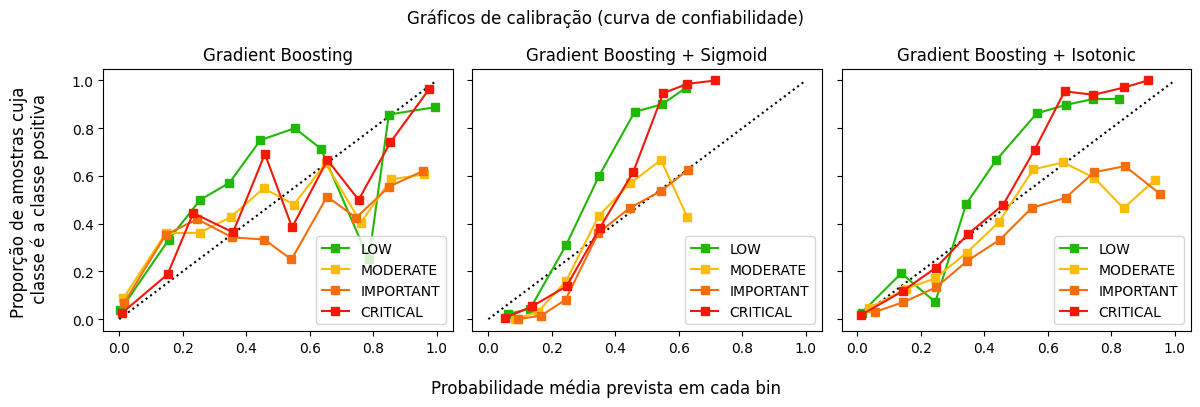

In [17]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4), tight_layout=True, sharey=True)

fig.suptitle('Gráficos de calibração (curva de confiabilidade)')
fig.supylabel("Proporção de amostras cuja\n classe é a classe positiva", horizontalalignment='center')
fig.supxlabel("Probabilidade média prevista em cada bin")

for ax, (cls, result, name) in zip(axes, clf_list):
        
    ax.set_title(name)
    ax.plot([0, 1], [0, 1], 'k:')

    for target, c in zip(range(n_classes), colors):
        prob_pos = result[target]
        
        fraction_of_positives, mean_predicted_value =\
            calibration_curve(get_y_true(result['y_test'], target), prob_pos, n_bins=10)

        ax.plot(mean_predicted_value, fraction_of_positives, "s-", label=classes[target], color=c)

    ax.legend(loc='lower right')

plt.savefig('calibration-plots.pdf', bbox_inches='tight', dpi=1200)
plt.show()

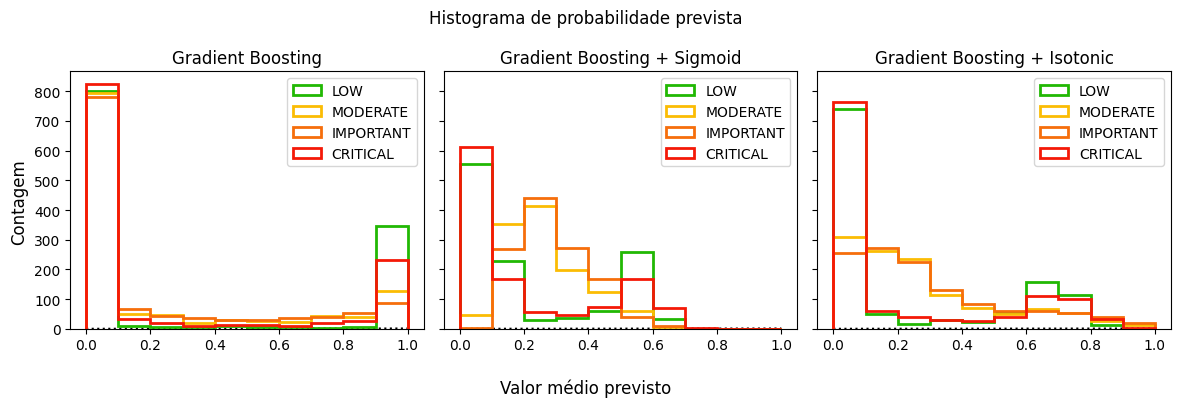

In [18]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4), tight_layout=True, sharey=True)

fig.suptitle('Histograma de probabilidade prevista')
fig.supxlabel('Valor médio previsto')
fig.supylabel('Contagem')

for ax, (cls, result, name) in zip(axes, clf_list):
    
    ax.set_title(name)
    ax.plot([0, 1], [0, 1], 'k:')

    for target, c in zip(range(n_classes), colors):
        prob_pos = result[target]
        ax.hist(prob_pos, range=(0, 1), bins=10, color=c, label=classes[target], histtype="step", lw=2)

    ax.legend(loc='upper right')
    
plt.savefig('predicted-probability-histogram.pdf', bbox_inches='tight', dpi=1200)
plt.tight_layout()
plt.show()

# [ROC](https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html)

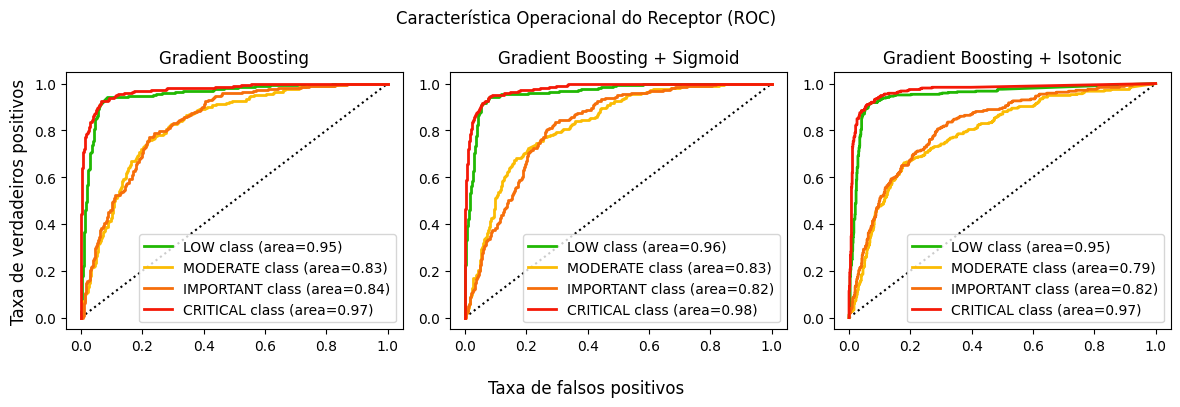

In [19]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4), tight_layout=True)

fig.suptitle('Característica Operacional do Receptor (ROC)')
fig.supxlabel('Taxa de falsos positivos')
fig.supylabel('Taxa de verdadeiros positivos')

for ax, (clf, result, name) in zip(axes, clf_list):
    
    y_score = result['proba']

    # computing ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(len(classes)):
        fpr[i], tpr[i], _ = roc_curve(get_y_true(result['y_test'], i), y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        
    # aggregating false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(classes))]))

    # interpolating ROC curves
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(len(classes)):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= len(classes)
    
    ax.set_title(name)
    ax.plot([0, 1], [0, 1], 'k:')
    
    for i, cls, c in zip(range(len(classes)), classes, colors):
        ax.plot(fpr[i], tpr[i], color=c, lw=2, label=f'{cls} class (area={roc_auc[i]:0.2f})')

    ax.legend(loc='lower right')

plt.savefig('receiver-operating-characteristic.pdf', bbox_inches='tight', dpi=1200)
plt.tight_layout()
plt.show()